# 0.a. Import and settings

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
from scanpy.plotting._tools.scatterplots import plot_scatter
import scanpy_scripts as ss
import bbknn

expr_cmap = ss.lib.expression_colormap(background_level=0.01)
doublet_cmap = ss.lib.expression_colormap(0.2)
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sc.settings.figdir = 'png'

In [3]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# 0.b. Define functions

In [4]:
def diffexp(
    adata, basis='umap', key=None, res=None, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=None, **kwargs
):
    if key:
        grp_key = f'{key}_r{str(res).replace(".", "_")}'
        basis=f'{basis}_{key}'
    else:
        grp_key = f'r{str(res).replace(".", "_")}'
    de_tbl = ss.lib.diffexp(
        adata, key_added=grp_key, groupby=f'leiden_{grp_key}', method=method,
        filter_params=filter_params, **kwargs,
    )
    de_genes = list(de_tbl.groupby('cluster').head(4)['genes'].values)
    if extra_genes:
        de_genes.extend(extra_genes)
    rcParams.update({'figure.figsize': (4,4)})
    sc.pl.rank_genes_groups(adata, key=f'rank_genes_groups_{grp_key}', show=False)

    sc.pl.dotplot(
        adata,
        var_names=de_genes,
        groupby=f'leiden_{grp_key}',
        #standard_scale='var',
        show=False
    )

    rcParams.update({'figure.figsize':(2.5,2.5)})
    plot_scatter(
        adata, basis=basis, color_map=expr_cmap, use_raw=True, ncols=8, size=10, color=de_genes, show=False)
    rcParams.update({'figure.figsize':(3,3)})
    ss.lib.plot_embedding(adata, basis=basis, groupby=f'leiden_{grp_key}', size=20, show=False)
    return de_tbl

In [5]:
def hex2rgba(hex_colors):
    return [tuple(int(h[i:i+2], 16)/255.0 for i in (1, 3, 5)) for h in hex_colors]

In [21]:
def check_doublets(
    ad, groupby, basis=None, p='bh_doublet_pval', score='scrublet_score', label='doublet', initial_pmin=0.05,
    upper_mad_only=(True, True), **kwargs
):
    if groupby not in ad.obs.columns:
        raise KeyError(f'{groupby} not found in `.obs`')
    ad.obs[label] = ad.obs[p] < initial_pmin
    doublet_freqs = ad.obs.groupby(groupby)[label].agg(lambda x: sum(x)/len(x))
    z_freq, p_freq, p_freq_adj = ss.lib.test_outlier(doublet_freqs, upper_mad_only=upper_mad_only)
    doublet_scores = ad.obs.groupby(groupby)[score].agg(lambda x: sum(x)/len(x))
    z_score, p_score, p_score_adj = ss.lib.test_outlier(doublet_scores, upper_mad_only=upper_mad_only)

    thresholds = {'min_score': max(doublet_scores)/2, 'min_freq': max(doublet_freqs)/2, 'max_p_score': 0.05, 'max_p_freq': 0.05}
    for k in thresholds:
        if k in kwargs:
            thresholds[k] = kwargs[k]
            del kwargs[k]

    if basis and f'X_{basis}' in ad.obsm.keys():
        ss.lib.set_figsize((3.5, 3.5))
        plot_scatter(ad, basis=basis, color=[score, label, groupby], color_map=doublet_cmap, legend_loc='on data', legend_fontsize=8, **kwargs)

    ss.lib.set_figsize((7,3))
    sc.pl.violin(ad, keys=[p, score], groupby=groupby)
    colors = hex2rgba(ad.uns[f'{groupby}_colors'])
    df = pd.DataFrame({'score': doublet_scores, 'p_score': p_score, 'freq': doublet_freqs, 'p_freq': p_freq})
    fig, ax = plt.subplots(ncols=2)
    df.plot(kind='scatter', x='p_score', y='p_freq', c=colors, ax=ax[0])
    ax[0].set_xlim((-0.02, 0.5))
    ax[0].set_ylim((-0.02, 0.5))
    ax[0].hlines(thresholds['max_p_freq'], xmin=0, xmax=1, linestyle='--', linewidth=1)
    ax[0].vlines(thresholds['max_p_score'], ymin=0, ymax=1, linestyle='--', linewidth=1)
    df.plot(kind='scatter', x='score', y='freq', c=colors, ax=ax[1])
#     ax[1].set_xlim((-1, 10))
    ax[1].set_ylim((-0.02, 0.5))
    ax[1].hlines(thresholds['min_freq'], xmin=min(doublet_scores), xmax=max(doublet_scores), linestyle='--', linewidth=1)
    ax[1].vlines(thresholds['min_score'], ymin=0, ymax=1, linestyle='--', linewidth=1)
    for i in range(len(p_freq)):
        ax[0].annotate(i, xy=(df.p_score[i], df.p_freq[i]))
        ax[1].annotate(i, xy=(df.score[i], df.freq[i]))
    ss.lib.set_figsize((3.5, 3.5))
    return df

# 1. Load data

In [7]:
CATEGORY_NAME = 'mast-cells'
CATEGORY_CLUSTER_ID = 5
MIN_BATCH_SIZE = 10
DE_METHOD = 't-test_overestim_var'
DE_FILTERS = {'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 1.5}
KNOWN_MARKERS = ['TPSB2']

In [6]:
# 1. Load data
fetal_ad = sc.read('data/h5ad/fetal_skin_raw.20190926.h5ad', mode='r')

# Restrict to category of interest
ad = fetal_ad[(fetal_ad.obs['hierarchy1'] == CATEGORY_CLUSTER_ID), :]

# Remove samples with too few cells
sample_sizes = ad.obs['sample'].value_counts()
valid_batches = sample_sizes[sample_sizes >= MIN_BATCH_SIZE].index.to_list()
ad = ad[ad.obs['sample'].isin(valid_batches), :]

ad.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}.h5ad', compression='gzip')

In [7]:
ad

AnnData object with n_obs × n_vars = 3218 × 33694 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1'
    var: 'gene_ids', 'cc'

# 2. QC

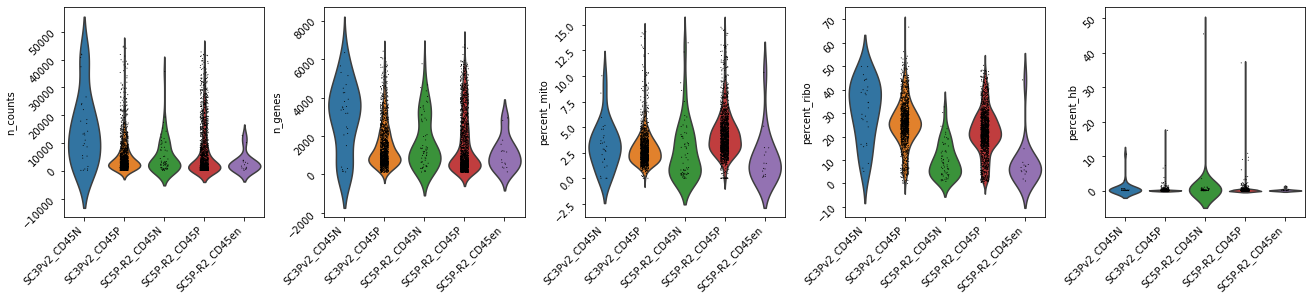

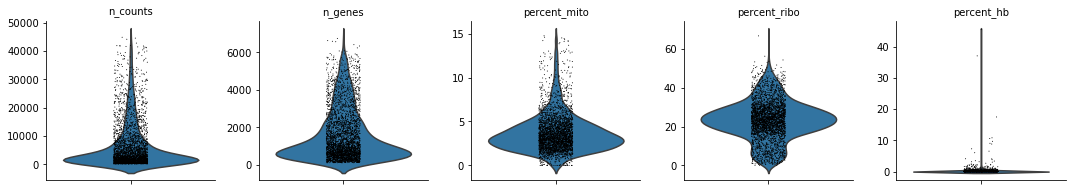

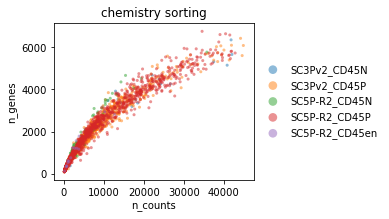

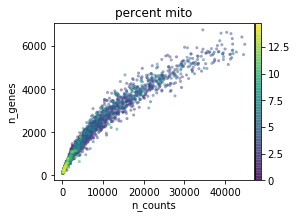

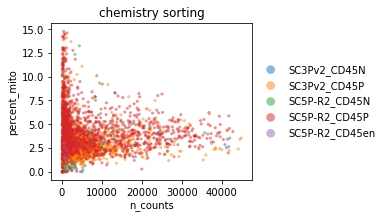

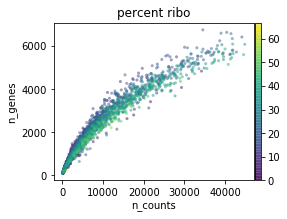

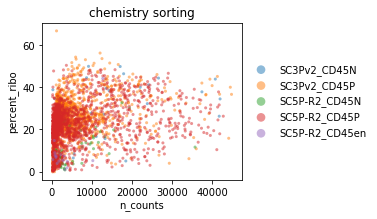

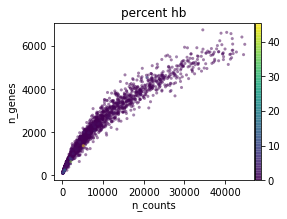

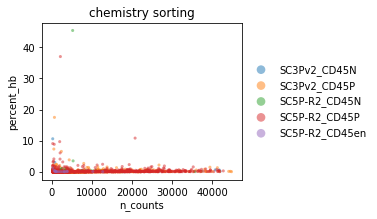

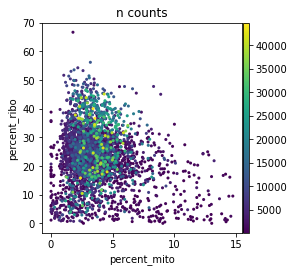

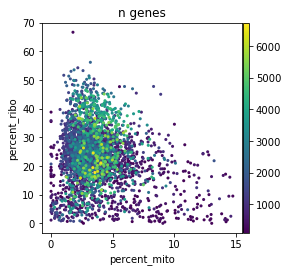

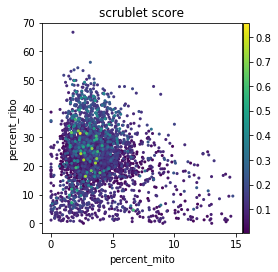

In [8]:
ss.lib.set_figsize((4,4))
ss.lib.simple_default_pipeline(ad, qc_only=True, batch='chemistry_sorting')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_counts')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_genes')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='scrublet_score')

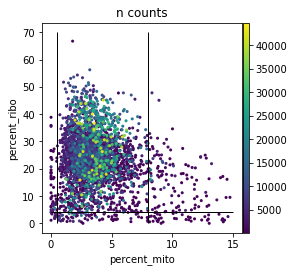

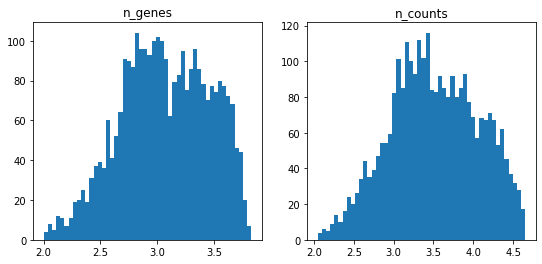

In [13]:
ss.lib.set_figsize((4,4))
ax = sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_counts', show=False)
ax.vlines(x=[0.5, 8], ymin=0, ymax=70, linewidth=1)
ax.hlines(y=4, xmin=0, xmax=15, linewidth=1)
ss.lib.set_figsize((9,4))
fig, ax = plt.subplots(ncols=2)
_ = ax[0].hist(np.log10(ad.obs.loc[(ad.obs['percent_mito']>0.5) & (ad.obs['percent_mito']<8) & (ad.obs['percent_ribo']>4), 'n_genes']), bins=50)
ax[0].set_title('n_genes')
_ = ax[1].hist(np.log10(ad.obs.loc[(ad.obs['percent_mito']>0.5) & (ad.obs['percent_mito']<8) & (ad.obs['percent_ribo']>4), 'n_counts']), bins=50)
ax[1].set_title('n_counts')
ss.lib.set_figsize((4,4))

# 3. Default preprocessing

In [14]:
MIN_PCT_MITO = 0.5
MAX_PCT_MITO = 8
MIN_PCT_RIBO = 4
MIN_N_GENE = 200
MIN_N_UMI = 300
MAX_PCT_HB = 2.5
MIN_N_CELL = 3
CLUSTER_RESOLUTIONS = [0.1, 0.2, 0.3, 0.4, 0.5]

In [15]:
ad = ad[
    (ad.obs.percent_mito >= MIN_PCT_MITO) &
    (ad.obs.percent_mito < MAX_PCT_MITO) &
    (ad.obs.percent_ribo >= MIN_PCT_RIBO) &
    (ad.obs.n_genes >= MIN_N_GENE) &
    (ad.obs.n_counts >= MIN_N_UMI) &
    (ad.obs.percent_hb < MAX_PCT_HB), :]
ad = ad[:, (ad.var.n_cells >= MIN_N_CELL)]

In [16]:
ad1 = ad.copy()[:, ~(ad.var.mito | ad.var.hb | ad.var.ribo)]

ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

k_annot = (ad1.obs['annot'] != 'nan').values
ad1.obs['lr_annot'] = ss.lib.LR_annotate(
    ad1, train_label=ad1.obs['annot'].values, train_x=ad1.obsm['X_pca'], subset=k_annot, use_rep='X_pca', return_label=True)
ad1.obs['lr_annot'] = ad1.obs['lr_annot'].astype('category')

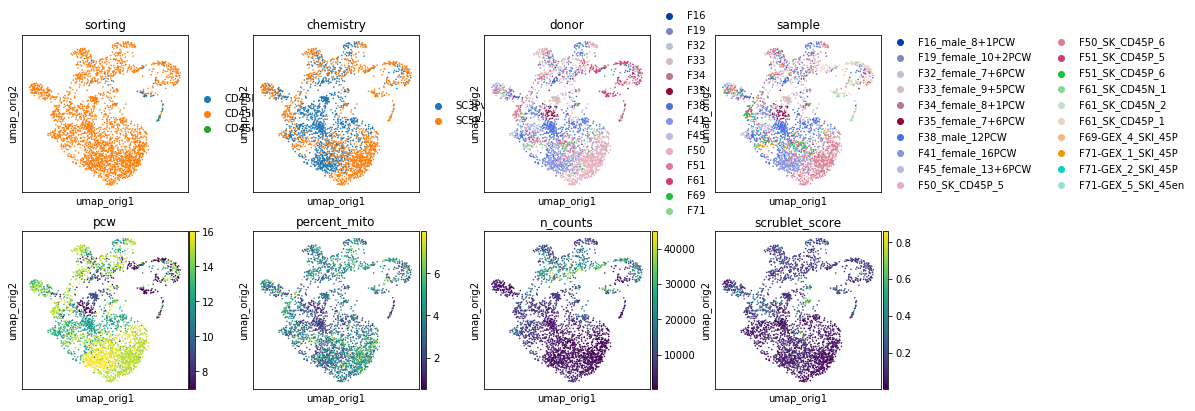

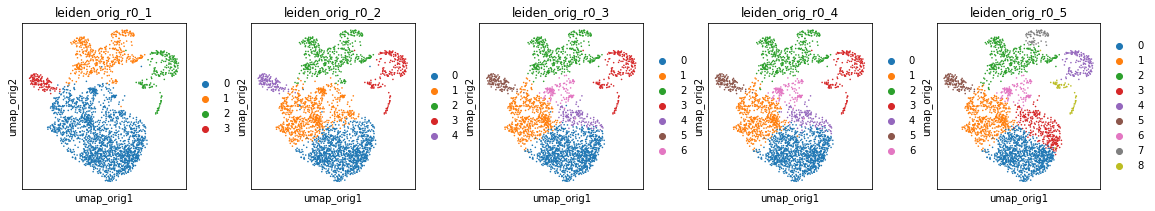

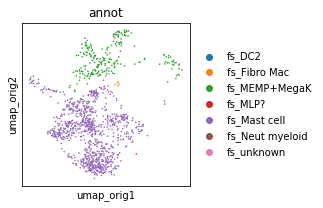

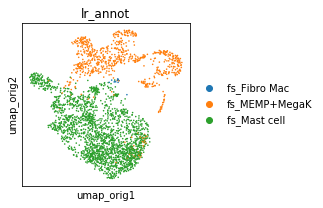

                      freq             p
leiden_orig_r0_3                        
0                 0.012100  7.553254e-01
1                 0.126079  2.751133e-13
2                 0.006329  7.553254e-01
3                 0.000000  7.862042e-01
4                 0.007353  7.553254e-01
5                 0.022388  5.833326e-01
6                 0.030303  4.072380e-01
                     score         p
leiden_orig_r0_3                    
0                 0.056801  0.908244
1                 0.100891  0.908244
2                 0.156939  0.875000
3                 0.146255  0.875000
4                 0.065778  0.908244
5                 0.155212  0.875000
6                 0.215851  0.875000


In [20]:
ad1.obs['doublet'] = ad1.obs['bh_doublet_pval'] < 0.05
ad1.obs['doublet'] = ad1.obs['doublet'].astype('category')
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_orig', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_orig', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(
    ad1[k_annot, :], basis='umap_orig', size=10,
    color='annot')
plot_scatter(
    ad1, basis='umap_orig', size=10,
    color='lr_annot')

doublet_freq = ad1.obs.groupby('leiden_orig_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_orig_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

In [18]:
ad2 = ad.copy()[:,~(ad.var.mito | ad.var.hb | ad.var.ribo | ad.var.cc)]

ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

k_annot = (ad2.obs['annot'] != 'nan').values
ad2.obs['lr_annot'] = ss.lib.LR_annotate(
    ad2, train_label=ad2.obs['annot'].values, train_x=ad2.obsm['X_pca'], subset=k_annot, use_rep='X_pca', return_label=True)
ad2.obs['lr_annot'] = ad2.obs['lr_annot'].astype('category')

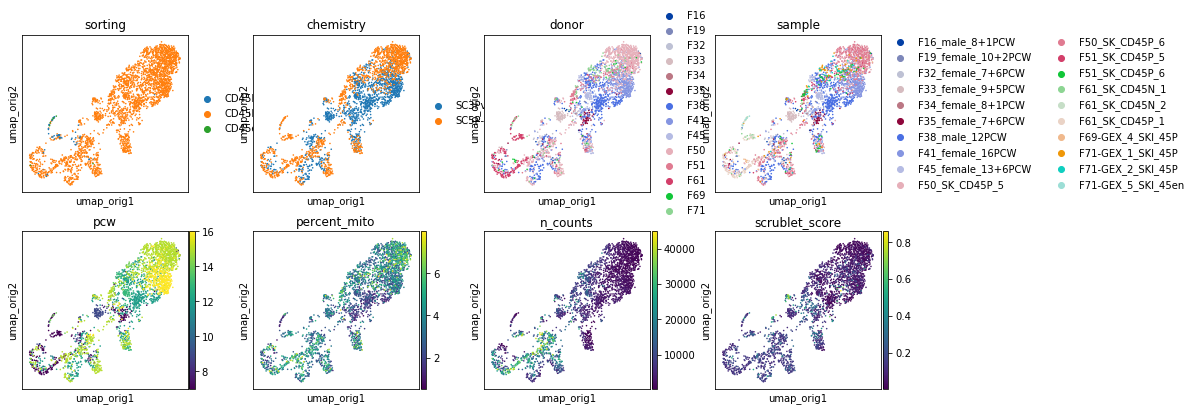

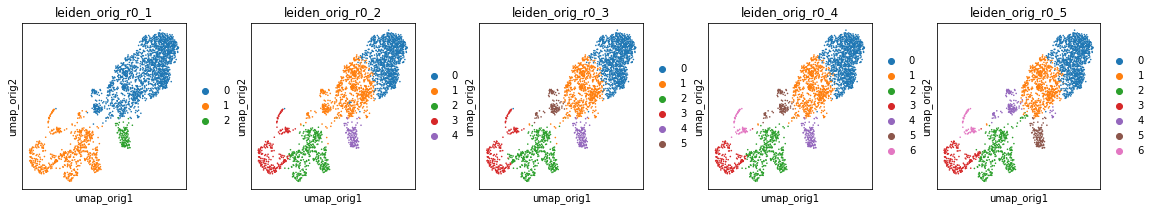

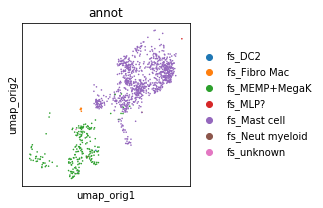

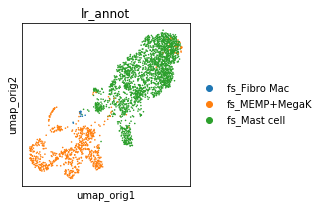

                      freq             p
leiden_orig_r0_3                        
0                 0.010135  8.128314e-01
1                 0.108853  4.971085e-08
2                 0.008621  8.128314e-01
3                 0.000000  8.377814e-01
4                 0.022222  7.128071e-01
5                 0.030769  5.612838e-01
                     score         p
leiden_orig_r0_3                    
0                 0.054208  0.986407
1                 0.100656  0.986407
2                 0.158834  0.834964
3                 0.143326  0.834964
4                 0.155614  0.834964
5                 0.213067  0.420946


In [21]:
ad2.obs['doublet'] = ad2.obs['bh_doublet_pval'] < 0.05
ad2.obs['doublet'] = ad2.obs['doublet'].astype('category')

ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_orig', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_orig', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_orig', size=10, color='annot')
plot_scatter(ad2, basis='umap_orig', size=10, color='lr_annot')


doublet_freq = ad2.obs.groupby('leiden_orig_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_orig_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

# 4.1 Harmony

In [22]:
ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
    harmony_params={'batch': 'sample', 'key_added': 'hm'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 2821 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_hm'
    

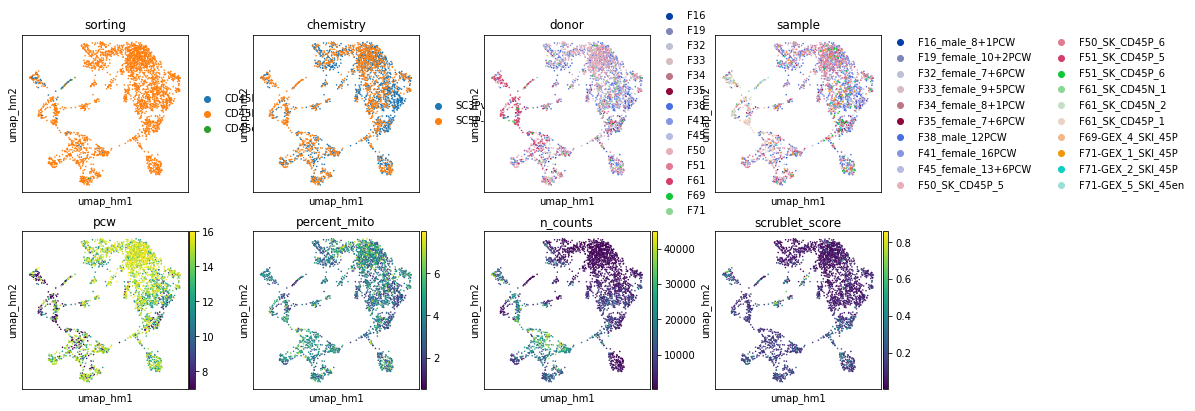

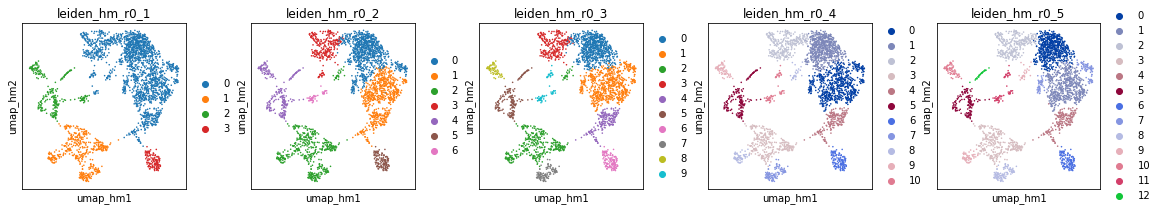

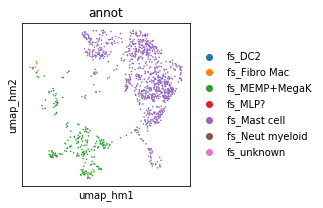

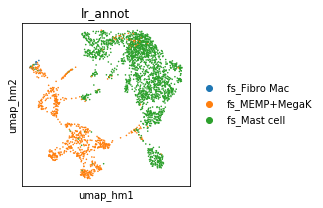

                    freq             p
leiden_hm_r0_3                        
0               0.012129  7.853494e-01
1               0.015850  7.853494e-01
2               0.013089  7.853494e-01
3               0.007752  8.244700e-01
4               0.303665  0.000000e+00
5               0.000000  8.244700e-01
6               0.036765  2.162483e-01
7               0.000000  8.244700e-01
8               0.014925  7.853494e-01
9               0.107692  1.114173e-09
                   score         p
leiden_hm_r0_3                    
0               0.045642  0.964247
1               0.067908  0.964247
2               0.162758  0.882560
3               0.053820  0.964247
4               0.177191  0.882560
5               0.138941  0.886800
6               0.153507  0.882560
7               0.163865  0.882560
8               0.223140  0.744105
9               0.277701  0.277045


In [23]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_hm', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_hm', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_hm_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad1[k_annot, :], basis='umap_hm', size=10, color='annot')
plot_scatter(ad1, basis='umap_hm', size=10, color='lr_annot')


doublet_freq = ad1.obs.groupby('leiden_hm_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_hm_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

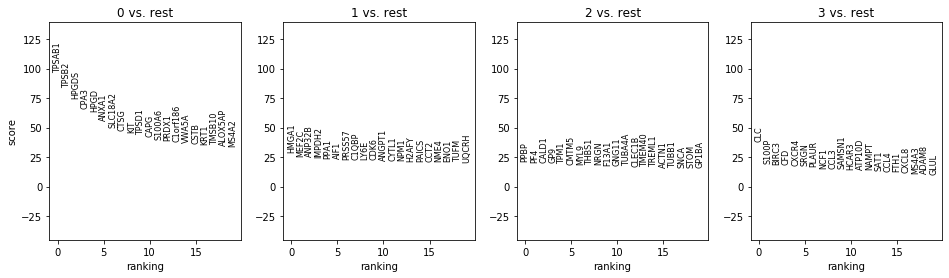

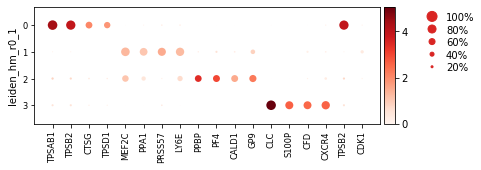

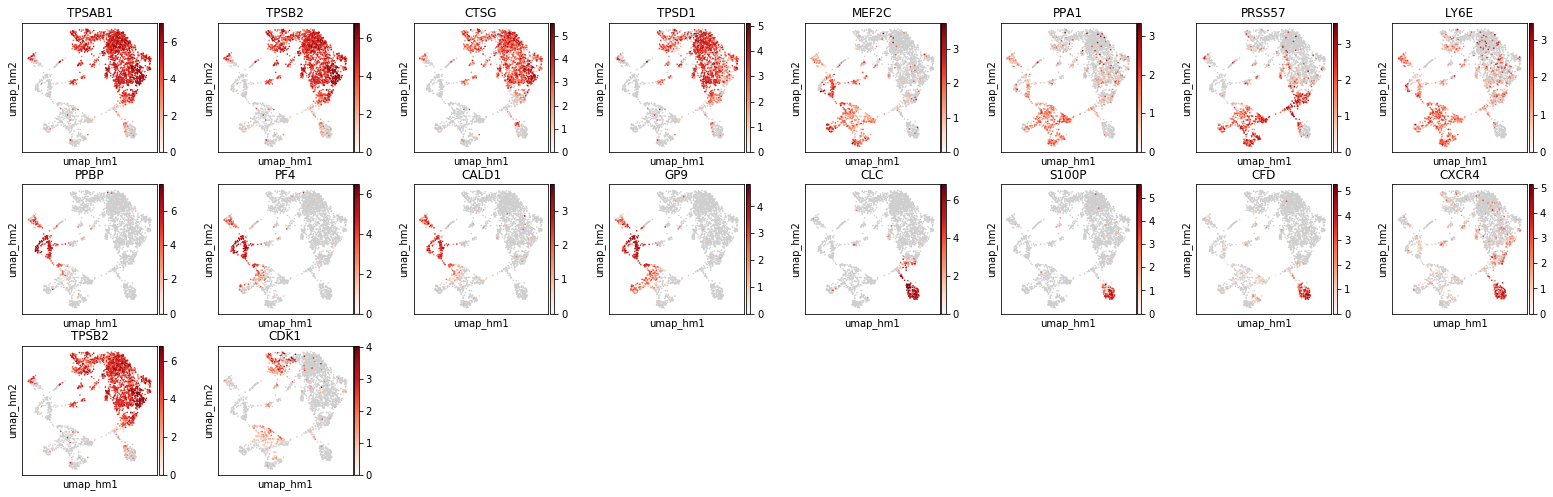

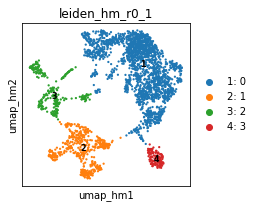

In [25]:
DE_RES = 0.1

hm_de_genes1 = diffexp(
    ad1, basis='umap', key='hm', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS + ['CDK1']
)
hm_de_genes1.groupby('cluster').head(5)

res = str(DE_RES).replace(".", "_")
hm_de_genes1.groupby('cluster').head(30).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_withCC_leiden_r{res}_DE_filtered_top30.txt', sep='\t', index=False)
ss.lib.extract_de_table(ad1.uns[f'rank_genes_groups_hm_r{res}']).groupby('cluster').head(200).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_withCC_leiden_r{res}_DE_top200.txt', sep='\t', index=False)

In [26]:
ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
    harmony_params={'batch': 'sample', 'key_added': 'hm'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 2821 × 17416 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_hm'
    

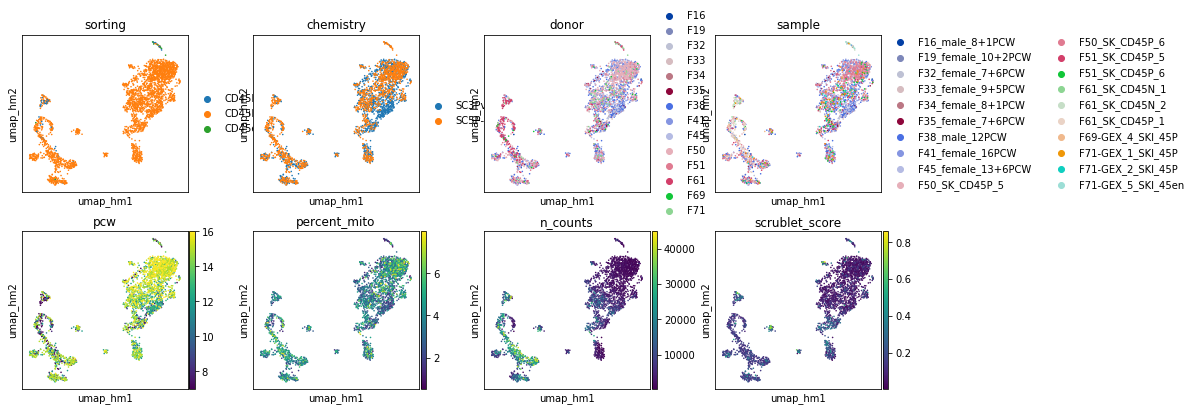

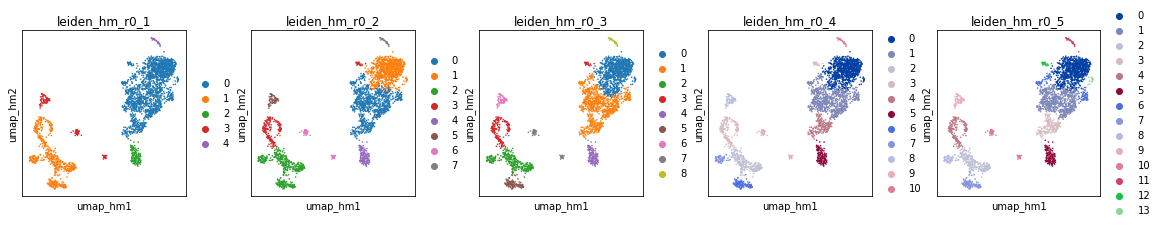

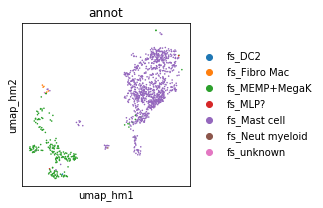

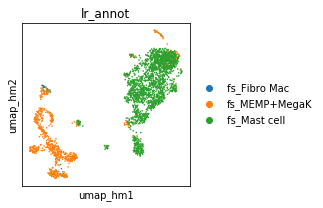

                    freq         p
leiden_hm_r0_1                    
0               0.041929  0.833333
1               0.006441  0.894724
2               0.042254  0.833333
3               0.064516  0.833333
4               0.000000  0.894724
                   score         p
leiden_hm_r0_1                    
0               0.070449  0.999830
1               0.153345  0.833333
2               0.157655  0.833333
3               0.255781  0.000024
4               0.137736  0.937500


In [29]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_hm', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_hm', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_hm_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_hm', size=10, color='annot')
plot_scatter(ad2, basis='umap_hm', size=10, color='lr_annot')


doublet_freq = ad2.obs.groupby('leiden_hm_r0_1')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_hm_r0_1')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

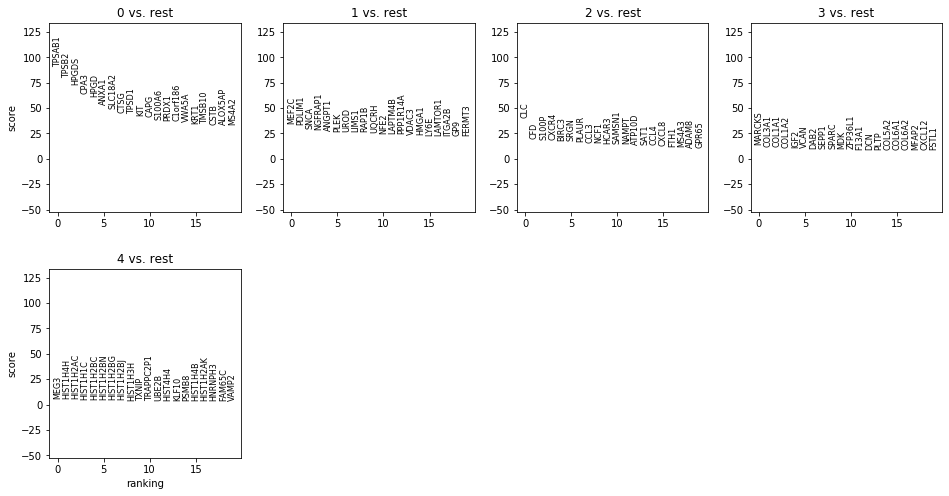

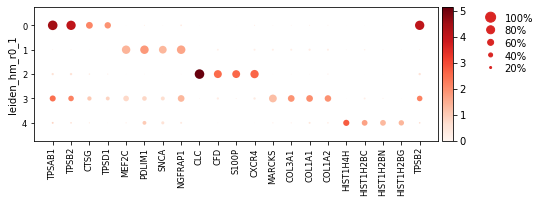

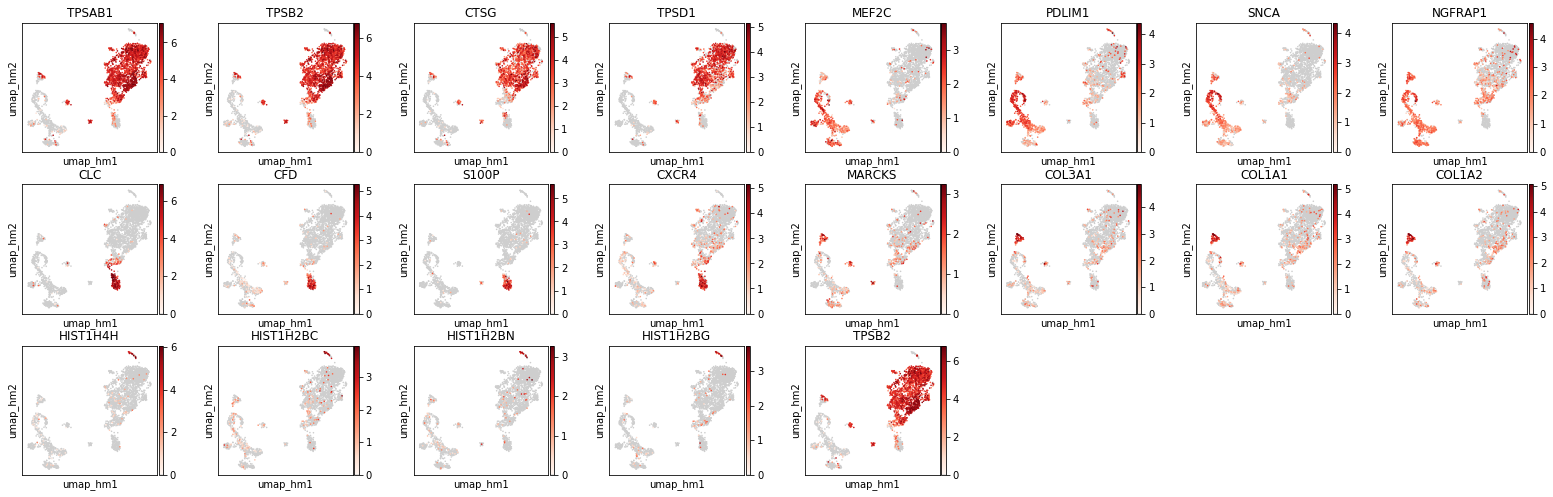

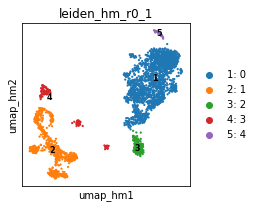

In [28]:
DE_RES = 0.1

hm_de_genes2 = diffexp(
    ad2, basis='umap', key='hm', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS
)
hm_de_genes2.groupby('cluster').head(5)

res = str(DE_RES).replace(".", "_")
# hm_de_genes2.groupby('cluster').head(30).to_csv(
#     f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_noCC_leiden_r{res}_DE_filtered_top30.txt', sep='\t', index=False)
# ss.lib.extract_de_table(ad2.uns[f'rank_genes_groups_hm_r{res}']).groupby('cluster').head(200).to_csv(
#     f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_noCC_leiden_r{res}_DE_top200.txt', sep='\t', index=False)

# 4.2 BBKNN

In [30]:
ad1.uns['neighbors'] = ad1.uns['neighbors_orig']
bbknn.bbknn(ad1, batch_key='sample', metric='euclidean', neighbors_within_batch=2, trim=15, copy=False)
ad1.uns['neighbors_bk'] = ad1.uns['neighbors']
ss.lib.umap(ad1, use_graph='neighbors_bk', key_added='bk')
ss.lib.leiden(ad1, use_graph='neighbors_bk', key_added='bk', resolution=CLUSTER_RESOLUTIONS)

AnnData object with n_obs × n_vars = 2821 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors'

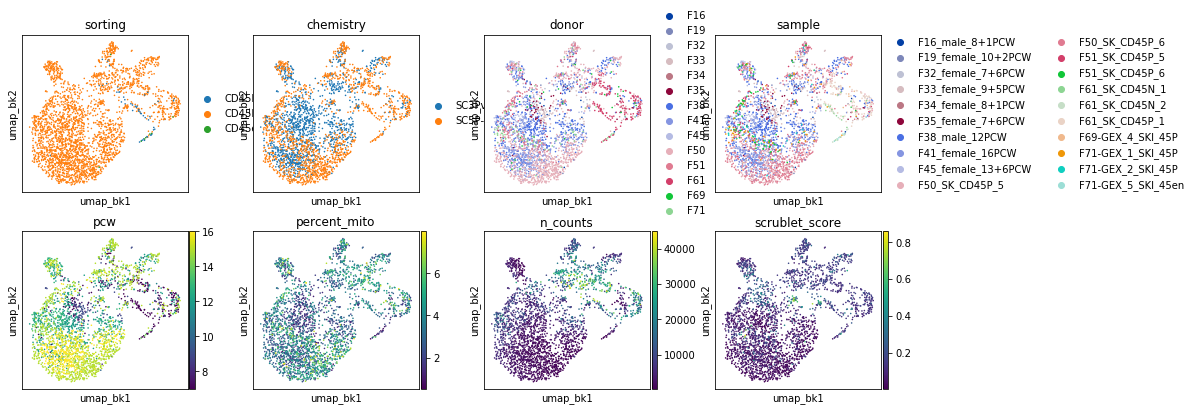

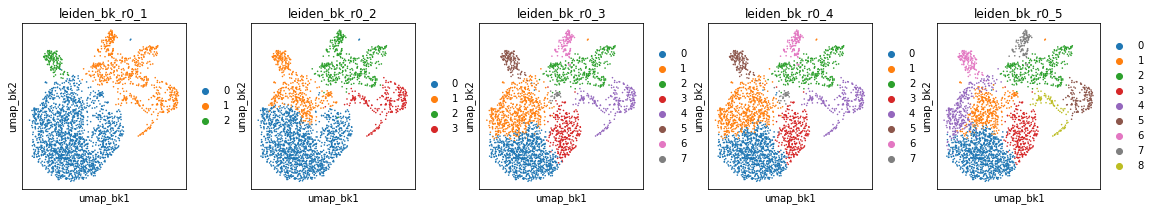

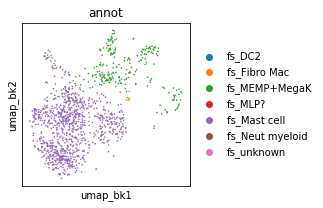

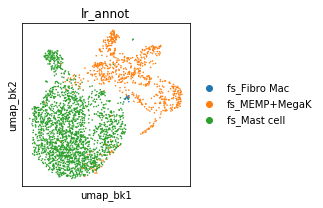

                    freq         p
leiden_bk_r0_2                    
0               0.014136  0.296356
1               0.145791  0.000000
2               0.006329  0.703644
3               0.004292  0.792198
                   score         p
leiden_bk_r0_2                    
0               0.057934  1.000000
1               0.165510  0.198106
2               0.156992  0.691665
3               0.163314  0.308335


In [33]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_bk', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_bk', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad1[k_annot, :], basis='umap_bk', size=10, color='annot')
plot_scatter(ad1, basis='umap_bk', size=10, color='lr_annot')


doublet_freq = ad1.obs.groupby('leiden_bk_r0_2')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_bk_r0_2')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

cluster   ref  rank   genes     scores  logfoldchanges          pvals  \
5           0  rest     5   TPSD1  39.976574        4.140551  2.490693e-270   
13          0  rest    13    KRT1  27.898535        3.117725  1.599039e-148   
17          0  rest    17   MS4A2  25.621773        2.791716  3.791673e-129   
19          0  rest    19   RGS13  24.359001        2.644882  1.595761e-118   
24          0  rest    24    UTS2  22.339899        2.928216  1.962499e-100   
17981       1  rest     4     CLC  16.688404        8.242754   6.664846e-50   
17982       1  rest     5    CCL3  16.629137        3.854372   5.815078e-52   
17988       1  rest    11   CXCR4  15.295271        3.943662   1.199649e-44   
17996       1  rest    19   MS4A3  14.416615        3.456753   4.050515e-41   
18001       1  rest    24   ADAM8  13.478481        2.901716   4.801975e-37   
35956       2  rest     2   MEF2C  26.094244        3.762074  1.293392e-111   
35958       2  rest     4    PPA1  24.467009        3.482339  3.051631e-100   
35961       2  rest     7  PRSS57  24.104481        3.567858   2.759409e-99   
35962       2  rest     8    CDK6  23.926685        3.756847   5.381620e-94   
35963       2  rest     9    LY6E  23.799013        3.091458   4.126111e-98   
53931       3  rest     0    PPBP  27.025146        9.927301   5.590912e-76   
53932       3  rest     1     PF4  26.239029        8.098604   2.897288e-77   
53933       3  rest     2   CALD1  25.384546        6.580345   4.533726e-73   
53934       3  rest     3     GP9  25.286419        6.272751   1.760025e-77   
53935       3  rest     4   CMTM5  23.626364        6.265954   1.462178e-68   

           pvals_adj  
5      7.462532e-267  
13     1.026640e-145  
17     1.450275e-126  
19     4.553490e-116  
24      3.207259e-98  
17981   1.331266e-46  
17982   1.742294e-48  
17988   1.268593e-41  
17996   3.640806e-38  
18001   3.453004e-34  
35956  3.875217e-108  
35958   4.219937e-97  
35961   3.543278e-96  
35962   5.374743e-91  
35963   4.635944e-95  
53931   3.350261e-72  
53932   2.604227e-73  
53933   2.037570e-69  
53934   2.604227e-73  
53935   4.380930e-65

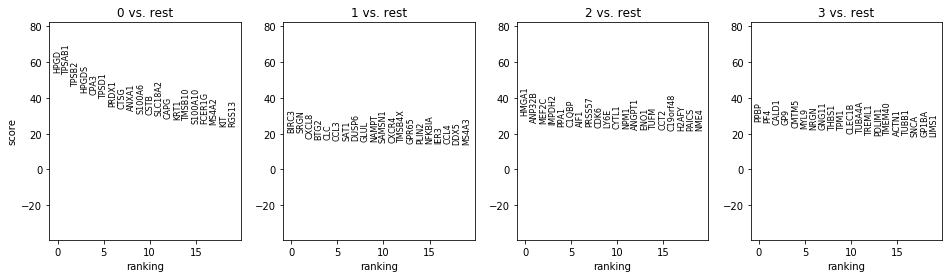

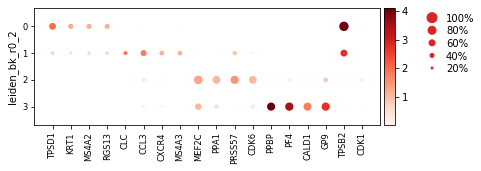

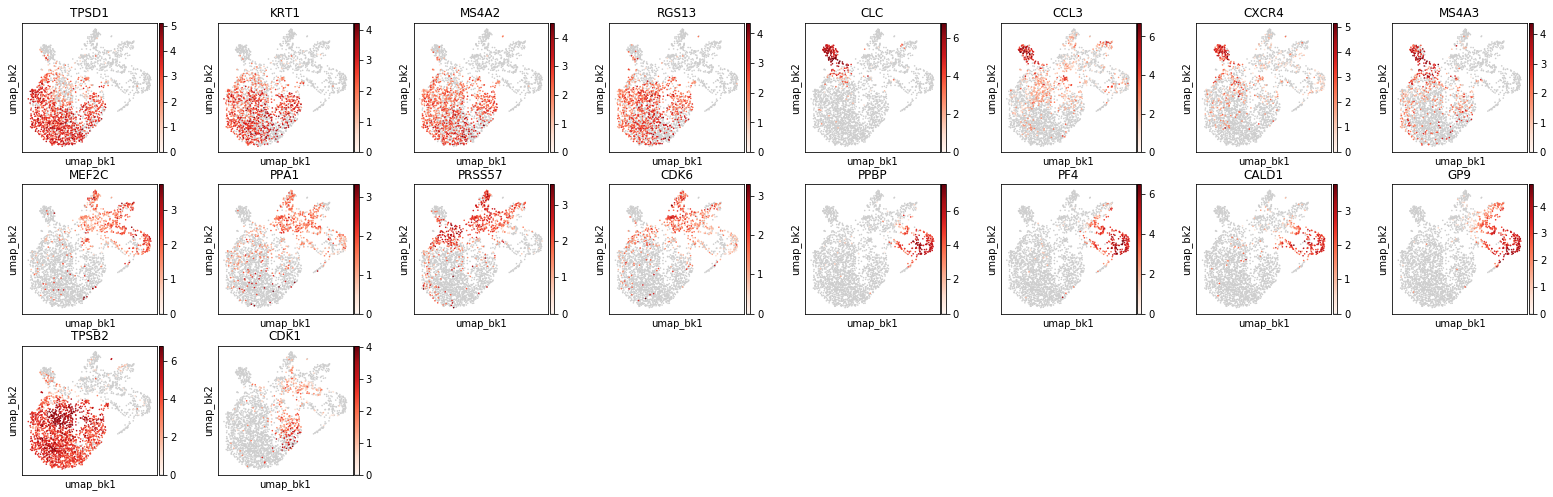

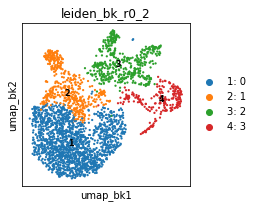

In [34]:
DE_RES = 0.2

bk_de_genes1 = diffexp(
    ad1, basis='umap', key='bk', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS + ['CDK1']
)
bk_de_genes1.groupby('cluster').head(5)

In [35]:
ad2.uns['neighbors'] = ad2.uns['neighbors_orig']
bbknn.bbknn(ad2, batch_key='sample', metric='euclidean', neighbors_within_batch=2, trim=15, copy=False)
ad2.uns['neighbors_bk'] = ad2.uns['neighbors']
ss.lib.umap(ad2, use_graph='neighbors_bk', key_added='bk')
ss.lib.leiden(ad2, use_graph='neighbors_bk', key_added='bk', resolution=CLUSTER_RESOLUTIONS)

AnnData object with n_obs × n_vars = 2821 × 17416 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors'

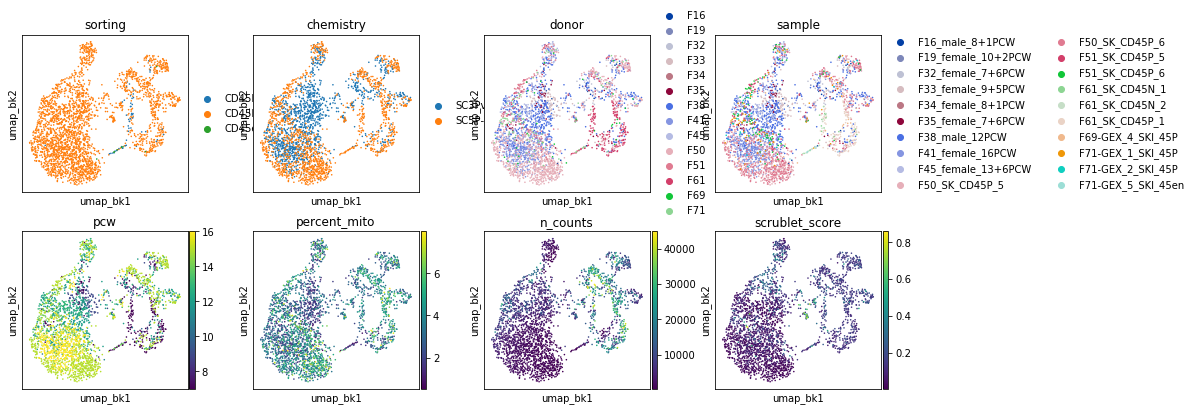

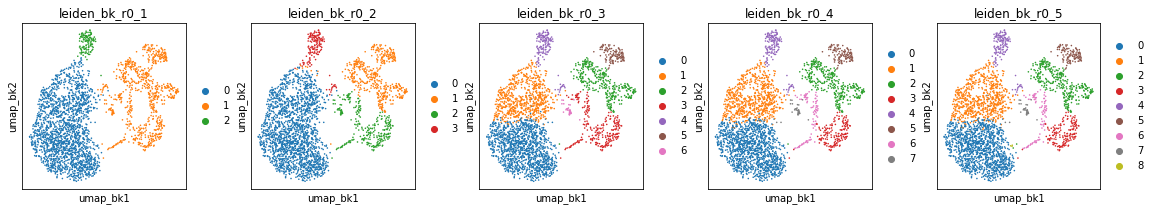

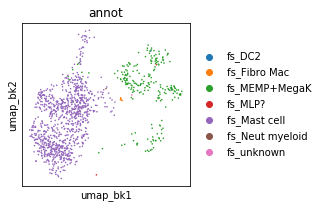

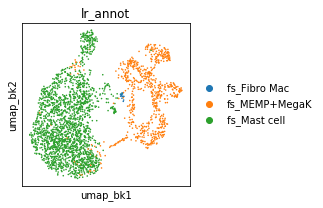

In [36]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_bk', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_bk', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_bk', size=10, color='annot')
plot_scatter(ad2, basis='umap_bk', size=10, color='lr_annot')

In [37]:
doublet_freq = ad2.obs.groupby('leiden_bk_r0_2')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_bk_r0_2')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                    freq         p
leiden_bk_r0_2                    
0               0.039728  0.274572
1               0.010799  0.773354
2               0.014035  0.725428
3               0.081250  0.005619
                   score         p
leiden_bk_r0_2                    
0               0.070427  1.000000
1               0.159391  0.561077
2               0.183887  0.115988
3               0.164973  0.438923


cluster   ref  rank   genes     scores  logfoldchanges          pvals  \
0           0  rest     0  TPSAB1  99.512169        7.295125   0.000000e+00   
1           0  rest     1   TPSB2  85.819847        6.788513   0.000000e+00   
7           0  rest     7    CTSG  47.001518        4.929680   0.000000e+00   
8           0  rest     8   TPSD1  46.634464        5.239826   0.000000e+00   
16          0  rest    16    KRT1  35.645447        4.434598  4.927331e-222   
17417       1  rest     1  PRSS57  27.023756        3.872430  1.918238e-117   
17420       1  rest     4    CDK6  24.969393        3.904742   3.231191e-99   
17421       1  rest     5   MEF2C  24.543491        3.615343  1.337135e-101   
17422       1  rest     6   CYTL1  24.178308        5.580437   1.721364e-87   
17425       1  rest     9    LY6E  22.827019        3.062561   2.169143e-91   
34832       2  rest     0    PPBP  25.031242       10.141273   1.264909e-74   
34833       2  rest     1     PF4  24.803505        8.038981   2.468851e-76   
34834       2  rest     2   CALD1  24.348289        6.777267   1.014684e-73   
34835       2  rest     3     GP9  24.150204        6.138865   8.347033e-77   
34836       2  rest     4   CMTM5  22.712549        6.224891   5.818756e-69   
52248       3  rest     0     CLC  29.413897       10.317174   3.624304e-71   
52249       3  rest     1     CFD  18.089417        7.082201   1.912914e-41   
52250       3  rest     2   S100P  17.545597        8.944201   2.005575e-39   
52252       3  rest     4   CXCR4  16.979563        5.427975   4.002934e-41   
52257       3  rest     9    NCF1  14.844345        7.348800   3.108510e-32   

           pvals_adj  
0       0.000000e+00  
1       0.000000e+00  
7       0.000000e+00  
8       0.000000e+00  
16     3.178311e-219  
17417  6.681606e-114  
17420   5.115856e-96  
17421   2.328754e-98  
17422   1.427584e-84  
17425   2.698414e-88  
34832   7.343217e-71  
34833   2.149875e-72  
34834   3.534349e-70  
34835   1.453719e-72  
34836   1.447706e-65  
52248   6.312088e-67  
52249   1.110510e-37  
52250   5.821516e-36  
52252   1.742877e-37  
52257   4.164446e-29

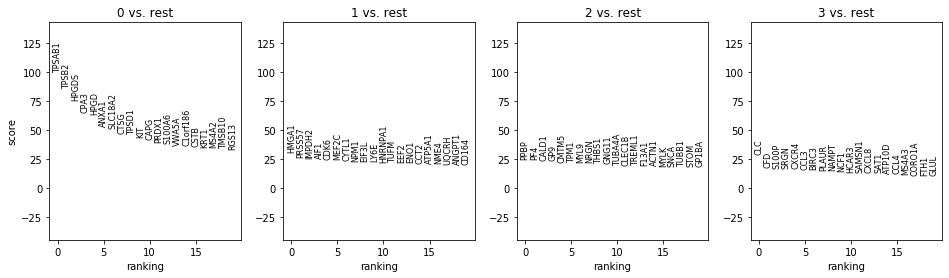

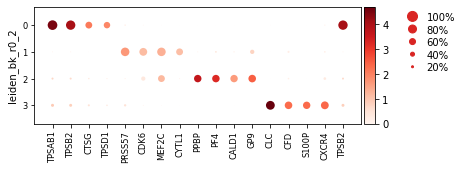

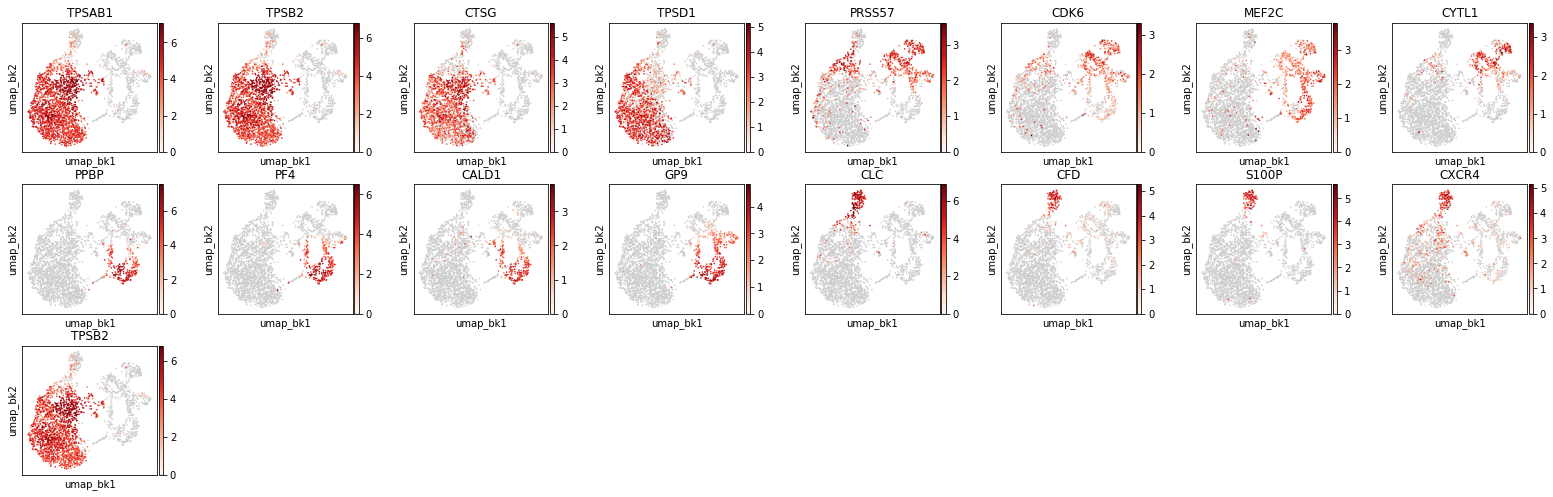

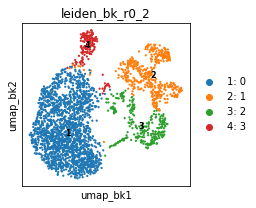

In [38]:
DE_RES = 0.2

bk_de_genes2 = diffexp(
    ad2, basis='umap', key='bk', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=KNOWN_MARKERS
)
bk_de_genes2.groupby('cluster').head(5)

# 5. Combine clustering and embeddings

In [39]:
ad1.obsm['X_umap_hm_nocc'] = ad2.obsm['X_umap_hm']
ad1.obsm['X_umap_bk_nocc'] = ad2.obsm['X_umap_bk']
for res in CLUSTER_RESOLUTIONS:
    r = str(res).replace(".", "_")
    ad1.obs[f'leiden_hm_nocc_r{r}'] = ad2.obs[f'leiden_hm_r{r}']
    ad1.obs[f'leiden_bk_nocc_r{r}'] = ad2.obs[f'leiden_bk_r{r}']

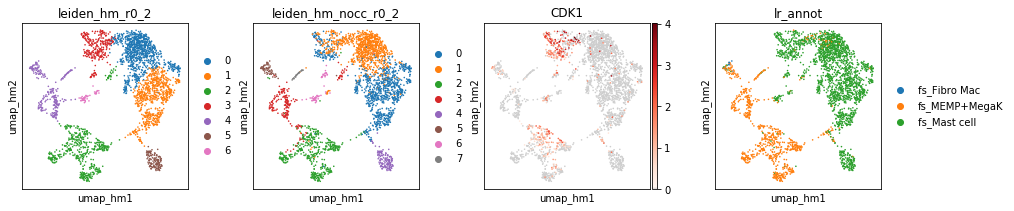

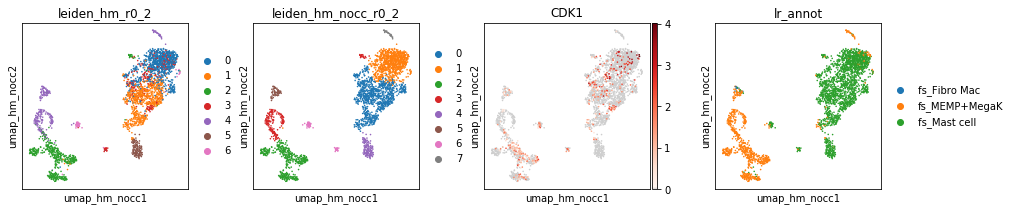

In [40]:
ss.lib.set_figsize((3,3))
plot_scatter(ad1, basis='umap_hm', size=10, color_map=expr_cmap,
             color=['leiden_hm_r0_2', 'leiden_hm_nocc_r0_2', 'CDK1', 'lr_annot'])
plot_scatter(ad1, basis='umap_hm_nocc', size=10, color_map=expr_cmap,
             color=['leiden_hm_r0_2', 'leiden_hm_nocc_r0_2', 'CDK1', 'lr_annot'])

In [41]:
ad1.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad', compression='gzip')
ad2.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad', compression='gzip')

In [364]:
# ad1 = sc.read('data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad')
# ad2 = sc.read(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad')

# 6. Incorporate annotation

In [8]:
ad1 = sc.read(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad')
ad2 = sc.read(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad')
ad1.uns['neighbors_hm_nocc'] = ad2.uns['neighbors_hm']
ad1.uns['neighbors_bk_nocc'] = ad2.uns['neighbors_bk']

In [9]:
ad1.obs['rachel_annot1'] = ad1.obs['leiden_hm_r0_1'].cat.rename_categories({
    '0': 'Mast cells',
    '1': 'MEMP',
    '2': 'Megakaryocyte',
    '3': 'Eosinophils',
})

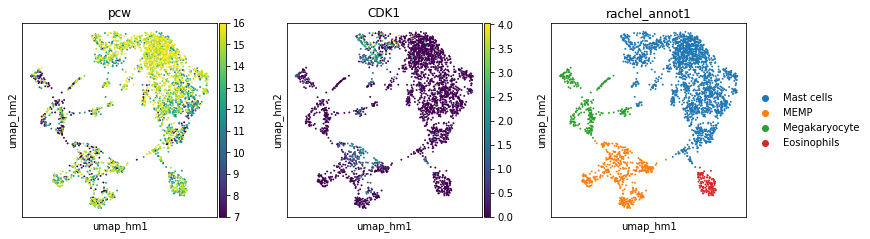

In [12]:
ss.lib.set_figsize((3.5, 3.5))
plot_scatter(ad1, basis='umap_hm', color=['pcw', 'CDK1', 'rachel_annot1'], size=15)

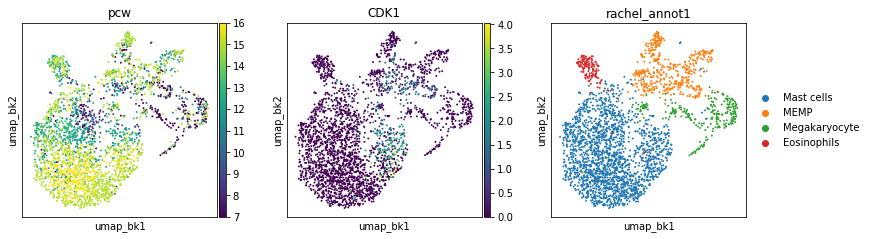

In [13]:
plot_scatter(ad1, basis='umap_bk', color=['pcw', 'CDK1', 'rachel_annot1'], size=15)

In [14]:
ss.lib.cross_table(ad1, 'annot', 'rachel_annot1', highlight=True)

# 7. Over-cluster to remove doublet

In [15]:
ad1

AnnData object with n_obs × n_vars = 2821 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_bk_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_bk_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'leiden_bk_nocc_r0_4', 'leiden_hm_nocc_r0_5', 'leiden_bk_nocc_r0_5', 'rachel_annot1', 'leiden_hm_r3_0', 'leiden_hm_r5_0', 'pooled_doublet', 'cluster_scrublet_z', 's

In [16]:
ss.lib.leiden(ad1, use_graph='neighbors_hm', resolution=[3.0], key_added='hm')

['leiden_hm_r3_0']

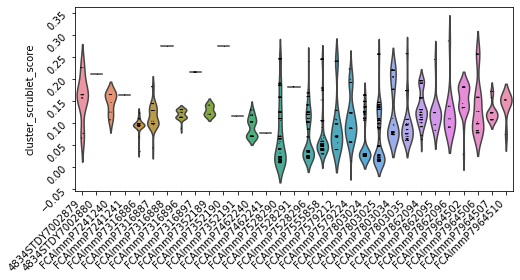

In [17]:
ss.lib.set_figsize((7, 3.5))
sc.pl.violin(ad1, keys='cluster_scrublet_score', groupby='sanger_id', rotation=45)

In [18]:
ad1.obs['scrublet_z'] = ad1.obs.groupby('sanger_id')['scrublet_score'].apply(lambda x: ss.lib.test_outlier(x, robust=True, upper_mad_only=True)[0])
ad1.obs['cluster_scrublet_z'] = ad1.obs.groupby('sanger_id')['cluster_scrublet_score'].apply(lambda x: ss.lib.test_outlier(x, robust=True, upper_mad_only=True)[0])

In [19]:
ad1.obs['cluster_scrublet_z'].describe()

count    2821.000000
mean        3.891956
std        20.998300
min        -4.571614
25%        -0.152482
50%         0.000000
75%         0.674491
max       151.760421
Name: cluster_scrublet_z, dtype: float64

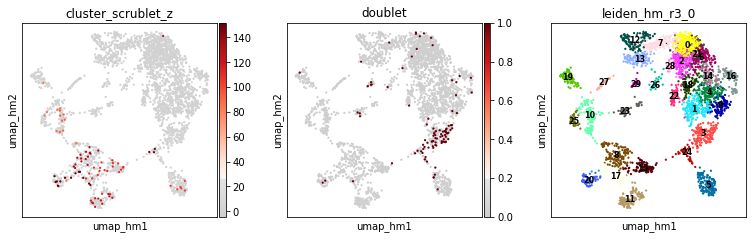

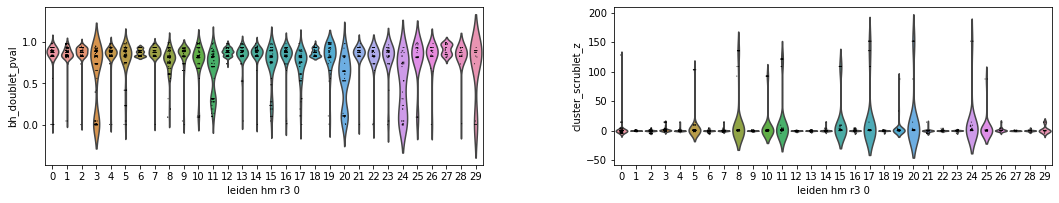

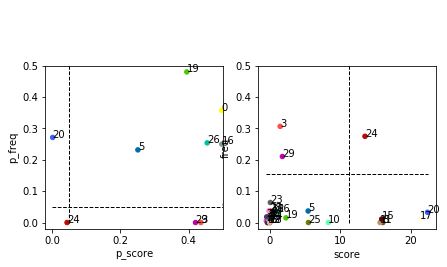

In [140]:
df = check_doublets(ad1, 'leiden_hm_r3_0', basis='umap_hm', p='bh_doublet_pval', score='cluster_scrublet_z', initial_pmin=0.05, size=20)

In [23]:
ad1.obs['pooled_doublet'] = ad1.obs['leiden_hm_r3_0'].isin(['3', '23', '24', '26', '29'])

In [24]:
ad1.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad', compression='lzf')

# 8. Trajectory

In [25]:
k_MEMP = (ad1.obs['rachel_annot1']=='MEMP') & (~ad1.obs['pooled_doublet'].values)

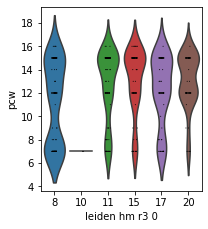

In [26]:
sc.pl.violin(ad1[k_MEMP, :], 'pcw', groupby='leiden_hm_r3_0')

In [27]:
ad1n = ad1[~ad1.obs['pooled_doublet'], :]

In [38]:
ss.lib.diffmap(ad1n, use_graph='neighbors_hm', key_added='hm')
ss.lib.neighbors(ad1n, use_rep='X_diffmap_hm', key_added='hm_dfmp')
ss.lib.umap(ad1n, use_graph='neighbors_hm_dfmp', key_added='hm_dfmp')

AnnData object with n_obs × n_vars = 2536 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_bk_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_bk_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'leiden_bk_nocc_r0_4', 'leiden_hm_nocc_r0_5', 'leiden_bk_nocc_r0_5', 'rachel_annot1', 'leiden_hm_r3_0', 'leiden_hm_r5_0', 'pooled_doublet', 'cluster_scrublet_z', 's

In [32]:
ss.lib.diffmap(ad1n, use_graph='neighbors_bk', key_added='bk')
ss.lib.neighbors(ad1n, use_rep='X_diffmap_bk', key_added='bk_dfmp')
ss.lib.umap(ad1n, use_graph='neighbors_bk_dfmp', key_added='bk_dfmp')

AnnData object with n_obs × n_vars = 2536 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_bk_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_bk_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'leiden_bk_nocc_r0_4', 'leiden_hm_nocc_r0_5', 'leiden_bk_nocc_r0_5', 'rachel_annot1', 'leiden_hm_r3_0', 'leiden_hm_r5_0', 'pooled_doublet', 'cluster_scrublet_z', 's

In [28]:
ss.lib.diffmap(ad1n, use_graph='neighbors_hm_nocc', key_added='hm_nocc')
ss.lib.neighbors(ad1n, use_rep='X_diffmap_hm_nocc', key_added='hm_nocc_dfmp')
ss.lib.umap(ad1n, use_graph='neighbors_hm_nocc_dfmp', key_added='hm_nocc_dfmp')

AnnData object with n_obs × n_vars = 2536 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_bk_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_bk_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'leiden_bk_nocc_r0_4', 'leiden_hm_nocc_r0_5', 'leiden_bk_nocc_r0_5', 'rachel_annot1', 'leiden_hm_r3_0', 'leiden_hm_r5_0', 'pooled_doublet', 'cluster_scrublet_z', 's

In [30]:
ss.lib.diffmap(ad1n, use_graph='neighbors_bk_nocc', key_added='bk_nocc')
ss.lib.neighbors(ad1n, use_rep='X_diffmap_bk_nocc', key_added='bk_nocc_dfmp')
ss.lib.umap(ad1n, use_graph='neighbors_bk_nocc_dfmp', key_added='bk_nocc_dfmp')

AnnData object with n_obs × n_vars = 2536 × 17977 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_bk_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_bk_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'leiden_bk_nocc_r0_4', 'leiden_hm_nocc_r0_5', 'leiden_bk_nocc_r0_5', 'rachel_annot1', 'leiden_hm_r3_0', 'leiden_hm_r5_0', 'pooled_doublet', 'cluster_scrublet_z', 's

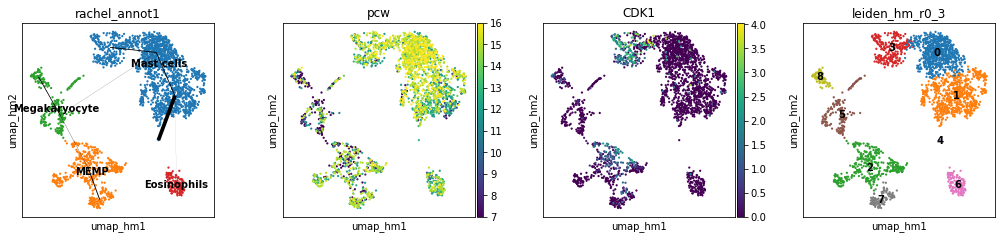

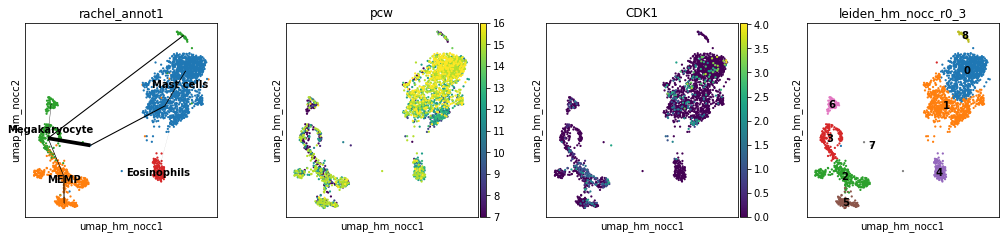

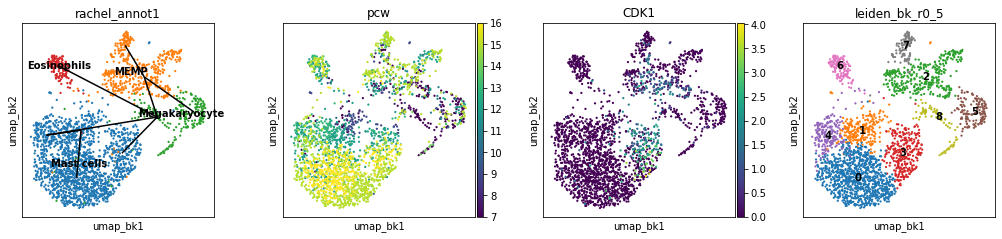

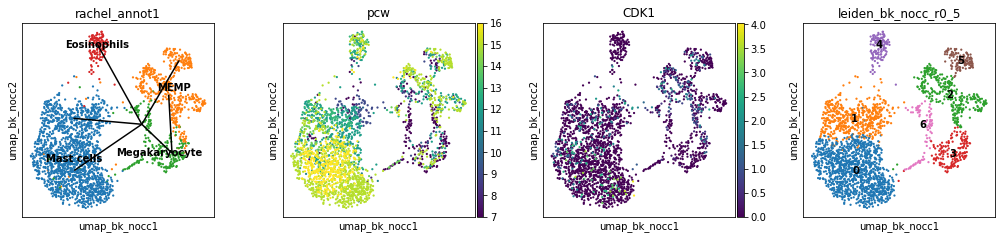

In [152]:
ss.lib.set_figsize((3.5, 3.5))

ss.lib.paga(ad1n, use_graph='neighbors_hm', key_added='hm', groups='leiden_hm_r0_3')
ss.lib.plot_paga(ad1n, basis='umap_hm', use_key='paga_hm', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_hm_r0_3'],
                 edge_width_scale=0.5, solid_edges='connectivities_tree', size=20)

ss.lib.paga(ad1n, use_graph='neighbors_hm_nocc', key_added='hm_nocc', groups='leiden_hm_nocc_r0_3')
ss.lib.plot_paga(ad1n, basis='umap_hm_nocc', use_key='paga_hm_nocc', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_hm_nocc_r0_3'],
                 edge_width_scale=0.5, solid_edges='connectivities_tree', size=20)

ss.lib.paga(ad1n, use_graph='neighbors_bk', key_added='bk', groups='leiden_bk_r0_5')
ss.lib.plot_paga(ad1n, basis='umap_bk', use_key='paga_bk', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_bk_r0_5'],
                 edge_width_scale=0.2, solid_edges='connectivities_tree', size=20)

ss.lib.paga(ad1n, use_graph='neighbors_bk_nocc', key_added='bk_nocc', groups='leiden_bk_nocc_r0_5')
ss.lib.plot_paga(ad1n, basis='umap_bk_nocc', use_key='paga_bk_nocc', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_bk_nocc_r0_5'],
                 root=4, edge_width_scale=0.2, solid_edges='connectivities_tree', size=20)

In [139]:
ad1n.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nodoublet_paga.h5ad', compression='lzf')